# Aperture Photometry and Registration of Project01

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import astropy
from astropy.table import table
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

from dlnpyutils import coords

import prometheus

The general premise of what I did came in a couple steps:
<ol>
    <li>Find target images for the analysis.</li>
    <li>Run those images through <a href=http://nova.astrometry.net/>astronomy.net</a> to get their appropriate WCS objects.</li>
    <li>Use Prometheus to do photometry.</li>
    <li>Transfer all the images onto one coordinate system. I did this using the WCS objects.</li>
    <li>The stars were then cross matched and compiled together.</li>
    <li>The processed and registered list of stars reported.</li>
</ol>

## 1. Finding the targets.
All the science images were plotted and the best canidates were picked out. For brevity only the finally chosen are shown:
<ul>
    <li>TransitSet11-0004B_proc.fits</li>
    <li>TransitSet11-0004G_proc.fits</li>
    <li>TransitSet11-0004R_proc.fits</li>
</ul>
out of all these, the red image looks the best. So, everything will be aligned to that image.

TransitSet11-0004B_proc.fits


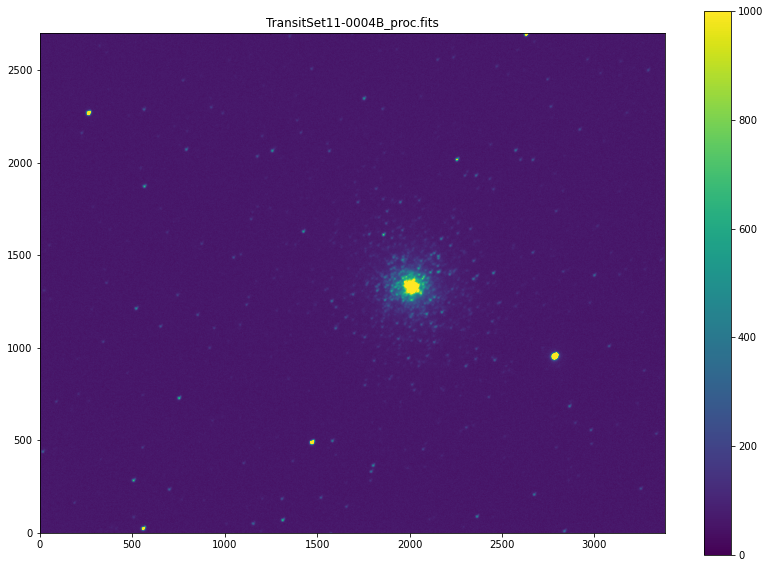

TransitSet11-0004G_proc.fits


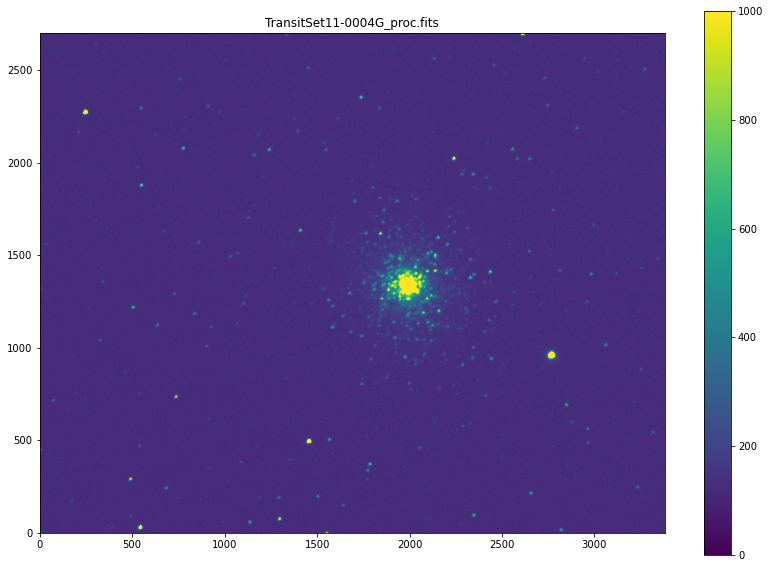

TransitSet11-0004R_proc.fits


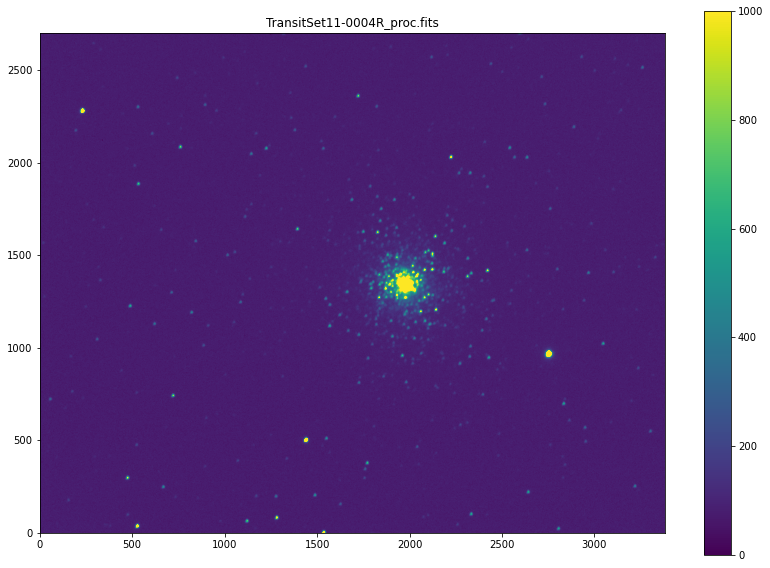

In [2]:
names = ['TransitSet11-0004B_proc.fits', 'TransitSet11-0004G_proc.fits', 'TransitSet11-0004R_proc.fits']
for i in names:
    print(i)
    im, head = fits.getdata(i, 0 , header=True)
    plt.figure(figsize=(14,10))
    plt.imshow(im, vmin = 0, vmax=1000, origin='lower')
    plt.title(i)
    plt.grid(False)
    plt.colorbar()
    plt.show()

## 2. Ran through Astronomy.net

In [3]:
# loading in WCS objects
wG_4 = WCS('0004G_wcs.fits')
wR_4 = WCS('0004R_wcs.fits')
wB_4 = WCS('0004B_wcs.fits')

## 3. Use Prometheus to do photometry
The data is run in through Prometeus, then passed to it to do the data analysis. We had to use the PSF photometry instead of apeture photometry because of the globular nature of the cluster (the stars overlaped too much). A penny function is used because that seemed to give the best results, especially for the center cluster activity. 

In [4]:
# Loading in all images and processing their photometry
print("Running 0004 Green:")
imG_4, headG_4 = fits.getdata('TransitSet11-0004G_proc.fits', 0 , header=True)
CCDDatG_4 = prometheus.ccddata.CCDData.read('TransitSet11-0004G_proc.fits')
catG_4,modelG_4,skyG_4,psfG_4 = prometheus.run(CCDDatG_4,'penny',verbose=True,lookup=True)
print()

print("Running 0004 Red:")
imR_4, headR_4 = fits.getdata('TransitSet11-0004R_proc.fits', 0 , header=True)
CCDDatR_4 = prometheus.ccddata.CCDData.read('TransitSet11-0004R_proc.fits')
catR_4,modelR_4,skyR_4,psfR_4 = prometheus.run(CCDDatR_4,'penny',verbose=True,lookup=True)
print()

print("Running 0004 Blue:")
imB_4, headB_4 = fits.getdata('CCD Image 363_proc.fits', 0 , header=True)
CCDDatB_4 = prometheus.ccddata.CCDData.read('TransitSet11-0004B_proc.fits')
catB_4,modelB_4,skyB_4,psfB_4 = prometheus.run(CCDDatB_4,'penny',verbose=True,lookup=True)

Running 0004 Green:
Step 1: Detection
931 objects detected
Step 2: Aperture photometry
Min/Max mag: 10.39, 16.52
Step 3: Construct the PSF
FWHM = 10.01 pixels (143 sources)
84 PSF stars found
Final PSF: PSFPenny([5.258307031759952, 4.832476328583957, 0.4, 0.10000000000000002, 5.0],binned=False,npix=51,lookup=True) FWHM=11.76
Median RMS:  0.1208
Step 4: Get PSF photometry for all 931 objects
Applying correction for exposure time 30.00 s
dt = 38.09 sec

Running 0004 Red:
Step 1: Detection
927 objects detected
Step 2: Aperture photometry
Min/Max mag: 10.11, 16.86
Step 3: Construct the PSF
FWHM =  9.72 pixels (178 sources)
91 PSF stars found
Final PSF: PSFPenny([4.719891578603204, 4.721470100152349, 0.0, 0.10000000000000002, 5.0],binned=False,npix=51,lookup=True) FWHM=10.92
Median RMS:  0.1165
Step 4: Get PSF photometry for all 927 objects
Applying correction for exposure time 30.00 s
dt = 16.92 sec

Running 0004 Blue:
Step 1: Detection
919 objects detected
Step 2: Aperture photometry
Min/

## 4. Registration to one image
Using the WCS objects, each image was cast to the sky, then the sky was translated to the red image's coordinates. The stars were then also transfered between the coordinates.

In [5]:
# Aligning WCS
cG_4 = SkyCoord(ra='21h29m36s', dec='12deg11m31s', frame='icrs')
wG_4.wcs.crval, wG_4.wcs.crpix = [[cG_4.ra.degree, cG_4.dec.degree], [2238.2, 2024.4]]
cR_4 = SkyCoord(ra='21h29m36s', dec='12deg11m31s', frame='icrs')
wR_4.wcs.crval, wR_4.wcs.crpix = [[cR_4.ra.degree, cR_4.dec.degree], [2223.1, 2031.9]]
cB_4 = SkyCoord(ra='21h29m36s', dec='12deg11m31s', frame='icrs')
wB_4.wcs.crval, wB_4.wcs.crpix = [[cB_4.ra.degree, cB_4.dec.degree], [2253.1, 2018.1]]

# Registering
points_G = wR_4.wcs_world2pix(np.array(wG_4.wcs_pix2world(catG_4['xc'], catG_4['yc'], 0)).T, 0).T
points_R = wR_4.wcs_world2pix(np.array(wR_4.wcs_pix2world(catR_4['xc'], catR_4['yc'], 0)).T, 0).T
points_B = wR_4.wcs_world2pix(np.array(wB_4.wcs_pix2world(catB_4['xc'], catB_4['yc'], 0)).T, 0).T

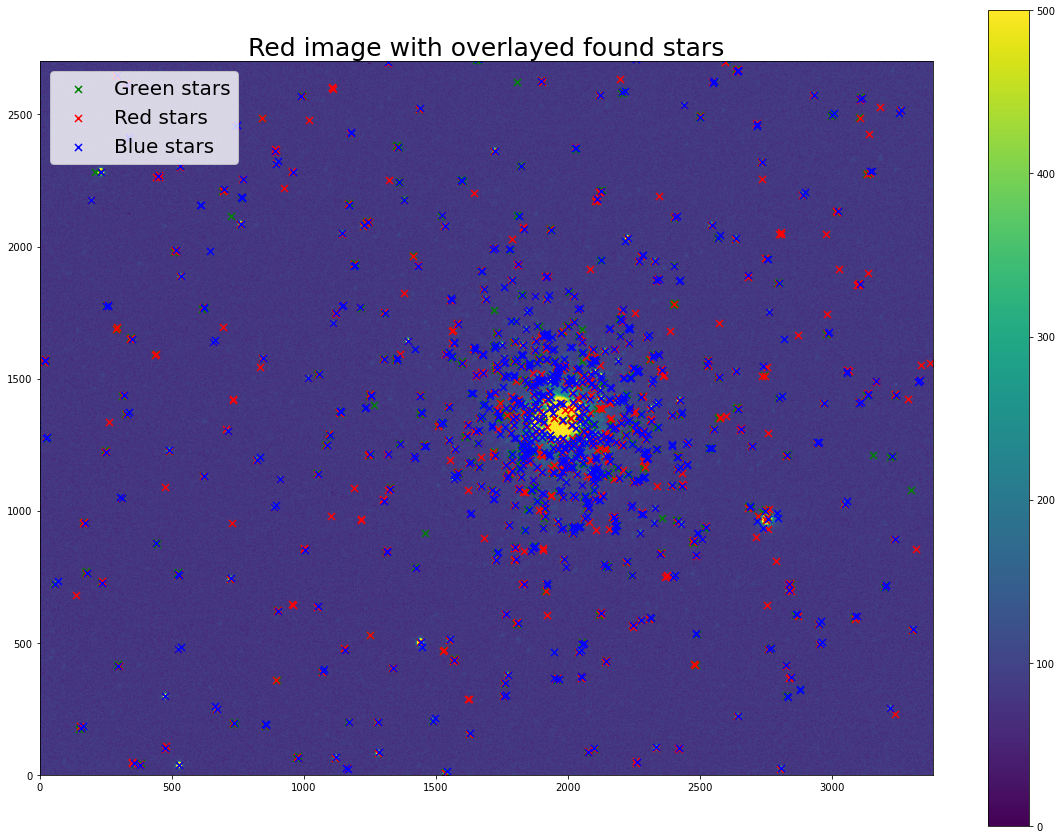

In [14]:
plt.figure(figsize=(20,15))

# notice, most of the green get hidden behind the red.
plt.scatter(points_G[0], points_G[1], marker='x', c='g', s=50, label='Green stars')
plt.scatter(points_R[0], points_R[1], marker='x', c='r', s=50, label='Red stars')
plt.scatter(points_B[0], points_B[1], marker='x', c='b', s=50, label='Blue stars')

plt.imshow(imR_4,vmin=0, vmax=500,origin='lower')
plt.legend(fontsize=20)
plt.colorbar()

plt.title('Red image with overlayed found stars', fontsize=25)
plt.show()

## 5. Cross matching
With how I did my code and registration, the xmatch given in Prometheus did not work for me. Consequently, I wrote my own quick match that finds the closest match between two colors (not allowing repeats).

In [7]:
def quick_xmatch(set_Data, new_Data, max_rad = 20):
    max_rad = max_rad**2
    trans_list = []
    dis_list = []
    for b in zip(new_Data[0], new_Data[1]):
        min_dis = (10e10, None)
        counter = 0
        for r in zip(set_Data[0], set_Data[1]):
            dist = (b[0]-r[0])**2 + (b[1]-r[1])**2
            if dist < min_dis[0]: min_dis = (dist, counter)
            counter += 1
        dis_list.append(min_dis[0])
        if min_dis[1] in trans_list:
            index = trans_list.index(min_dis[1])
            if min_dis[0] < dis_list[index]:
                trans_list.append(min_dis[1])
                trans_list[index] = None
            else:
                trans_list.append(None)
        else:
            trans_list.append(min_dis[1])
        if min_dis[0] > max_rad: trans_list[-1] = None
    return trans_list

In [8]:
def mag_match(match_list, give_target, get_target, get_dat, comped = points_R):
    count = -1
    for match in match_list:
        count += 1
        if match == None: continue
        row = all_mags[(all_mags['xc'] == comped[0, match]) & (all_mags['yc'] == comped[1, match])]
        row[give_target] = get_dat[count][get_target]
        all_mags[(all_mags['xc'] == comped[0, match]) & (all_mags['yc'] == comped[1, match])] = row
        all_mags[(all_mags['xc'] == comped[0, match]) & (all_mags['yc'] == comped[1, match])]

In [9]:
# Create the table to hold all the data
all_mags = table.Table()
all_mags['xc'] = points_R[0]
all_mags['yc'] = points_R[1]
all_mags['MAG_3R'] = catR_4['mag_auto']
all_mags['MAG_3G'] = None
all_mags['MAG_3B'] = None

In [10]:
# Cross matching
trans_list_B = quick_xmatch(points_R, points_B)
trans_list_G = quick_xmatch(points_R, points_G)

In [11]:
# Entering matches into the table
mag_match(trans_list_B, 'MAG_3B', 'mag_auto', catB_4)
mag_match(trans_list_G, 'MAG_3G', 'mag_auto', catG_4)

In [12]:
# Removing stars that didn't find a match in all three colors
all_mags = all_mags[all_mags['MAG_3B'] != None]
all_mags = all_mags[all_mags['MAG_3G'] != None]

## 6. Reporting the registared stars

In [13]:
all_mags

xc,yc,MAG_3R,MAG_3G,MAG_3B
float64,float64,float64,object,object
1534.88184155581,5.308114044504009,11.310918881264282,12.788883832514717,15.348129977038509
2803.8535215351258,23.67342501686403,12.48617014586098,12.464157683009487,13.034722755982473
378.82302224909995,37.80761478872387,15.170677857731361,14.753726434687655,16.337928201632447
354.0310261354198,44.19222208123233,16.000378658025998,15.399831581097672,16.929509892946164
526.1449321249161,37.47332400616324,10.77288556652507,10.530390355384702,10.827484346001611
2257.5412384315127,45.39874482178698,14.329877271611375,14.61407812802647,15.76284489268813
977.5861745974842,65.15160023410772,15.155898711460827,14.860862872471623,15.338526555971274
1119.2421790071853,64.92989531642843,12.122340232763051,12.376383190596066,13.075195551802041
2074.3358703167696,85.66470906055179,14.777434247280627,14.536180599177854,15.373902022271967
